In [1]:
import torch
from torch import nn
import time
import pandas as pd

In [5]:
number_of_steps = 20
# Create an empty DataFrame to hold experments data
results = pd.DataFrame(columns=["step"])
# fill step column data
results["step"] = range(number_of_steps)

In [25]:
## flash-attention and mem_efficient-attention is enabled by default, so We wil disable it and re-enable it again at its section.
torch.backends.cuda.enable_flash_sdp(enabled=False)
torch.backends.cuda.enable_mem_efficient_sdp(enabled=False)

## Model that we will test on.

The model we will be testing on is part of the NMT-MultiModel-Training-Framework project. You can find the implementation
[NMT_Transformer](https://github.com/abdo-ashraf/NMT-MultiModel-Training-Framework/blob/main/Models/Transformer_model.py)

In [8]:
class NMT_Transformer(nn.Module):
    def __init__(self, vocab_size:int, dim_embed:int,
                 dim_model:int, dim_feedforward:int, num_layers:int,
                 dropout_probability:float, maxlen:int):
        """
        Neural Machine Translation Transformer model.
        
        Args:
            vocab_size: Size of the vocabulary
            dim_embed: Dimension of the embedding vectors
            dim_model: Dimension of the model (hidden size)
            dim_feedforward: Dimension of the feedforward network in transformer layers
            num_layers: Number of encoder and decoder layers
            dropout_probability: Dropout rate
            maxlen: Maximum sequence length for positional embeddings
        """
        super().__init__()

        # Shared embeddings for source and target tokens
        self.embed_shared_src_trg_cls = nn.Embedding(num_embeddings=vocab_size, embedding_dim=dim_embed)
        # Shared positional embeddings for source and target sequences
        self.positonal_shared_src_trg = nn.Embedding(num_embeddings=maxlen, embedding_dim=dim_embed)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_probability)

        # Create encoder layer with specified parameters
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_model, nhead=8,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout_probability,
                                                   batch_first=True, norm_first=True)
        # Stack multiple encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, enable_nested_tensor=False)

        # Create decoder layer with specified parameters
        decoder_layer = nn.TransformerDecoderLayer(d_model=dim_model, nhead=8,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout_probability,
                                                   batch_first=True, norm_first=True)
        # Stack multiple decoder layers
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Output projection layer to vocabulary size
        self.classifier = nn.Linear(dim_model, vocab_size)
        # Weight sharing between embedding and output projection (tied embeddings)
        self.classifier.weight = self.embed_shared_src_trg_cls.weight

        self.maxlen = maxlen
        # Initialize model weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Initialize the weights of the model using standard transformer initialization.
        
        Args:
            module: Module to initialize
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            torch.nn.init.zeros_(module.bias)
    
    def forward(self, source, target, pad_tokenId):
        """
        Forward pass of the NMT Transformer.
        
        Args:
            source: Source sequence tensor [batch_size, source_seq_len]
            target: Target sequence tensor [batch_size, target_seq_len]
            pad_tokenId: Token ID used for padding
            
        Returns:
            logits: Output logits [batch_size, target_seq_len, vocab_size]
            loss: Cross-entropy loss if target length > 1, otherwise None
        """
        # Get batch size and sequence lengths
        B, Ts = source.shape
        B, Tt = target.shape
        device = source.device
        
        ## Encoder Path
        # Create positional embeddings for source sequence
        src_poses = self.positonal_shared_src_trg(torch.arange(0, Ts).to(device).unsqueeze(0).repeat(B, 1))
        # Combine token embeddings with positional embeddings and apply dropout
        src_embedings = self.dropout(self.embed_shared_src_trg_cls(source) + src_poses)

        # Create padding mask for source sequence
        src_pad_mask = source == pad_tokenId
        # Pass through encoder to get memory
        memory = self.transformer_encoder(src=src_embedings, mask=None, src_key_padding_mask=src_pad_mask, is_causal=False)
        
        ## Decoder Path
        # Create positional embeddings for target sequence
        trg_poses = self.positonal_shared_src_trg(torch.arange(0, Tt).to(device).unsqueeze(0).repeat(B, 1))
        # Combine token embeddings with positional embeddings and apply dropout
        trg_embedings = self.dropout(self.embed_shared_src_trg_cls(target) + trg_poses)
        
        # Create padding mask for target sequence
        trg_pad_mask = target == pad_tokenId
        # Create causal mask to prevent attending to future tokens
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(Tt, dtype=bool).to(device)
        # Pass through decoder
        decoder_out = self.transformer_decoder.forward(tgt=trg_embedings,
                                                memory=memory,
                                                tgt_mask=tgt_mask,
                                                memory_mask=None,
                                                tgt_key_padding_mask=trg_pad_mask,
                                                memory_key_padding_mask=None)
        
        ## Classifier Path
        # Project decoder output to vocabulary space
        logits = self.classifier(decoder_out)
        
        # Calculate loss if we have more than one target token
        loss = None
        if Tt > 1:
            # For model logits we need all tokens except the last one
            flat_logits = logits[:,:-1,:].reshape(-1, logits.size(-1))
            # For targets we need all tokens except the first one (shift right)
            flat_targets = target[:,1:].reshape(-1)
            # Calculate cross-entropy loss, ignoring padding tokens
            loss = nn.functional.cross_entropy(flat_logits, flat_targets, ignore_index=pad_tokenId)
        return logits, loss

In [9]:
vocab_size = 5000
dim_embed = 512
dim_model = 512
dim_feedforward = 512*4
num_layers = 3
dropout_probability = 0.1
maxlen = 50

batch_size = 256 # reduce batch_size incase of insufficient memory error
num_batch = 50
data_x = torch.randint(0, 5000, (num_batch, batch_size, 50))
data_y = torch.randint(0, 5000, (num_batch, batch_size, 20))

## No Optimization

In [11]:
model = NMT_Transformer(vocab_size=vocab_size,
                    dim_embed=dim_embed,
                    dim_model=dim_model,
                    dim_feedforward=dim_feedforward,
                    num_layers=num_layers,
                    dropout_probability=dropout_probability,
                    maxlen=maxlen)
model.to('cuda')

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

dts = []
for i in range(number_of_steps):
    t1 = time.time()
    x = data_x[i].to('cuda')
    y = data_y[i].to('cuda')

    optimizer.zero_grad()
    logits, loss = model(x, y, 0)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t2 = time.time()
    dt = (t2 - t1)*1000
    dts.append(round(dt, 2))
    print(f"step {i}, loss: {loss.item():.2f}, dt: {dt:.2f}ms")
results["no_optimization"] = dts
print(logits.dtype)

step 0, loss: 8.58, dt: 725.97ms
step 1, loss: 8.65, dt: 487.70ms
step 2, loss: 8.61, dt: 457.88ms
step 3, loss: 8.60, dt: 473.04ms
step 4, loss: 8.59, dt: 474.77ms
step 5, loss: 8.60, dt: 475.53ms
step 6, loss: 8.59, dt: 472.96ms
step 7, loss: 8.59, dt: 475.89ms
step 8, loss: 8.59, dt: 473.91ms
step 9, loss: 8.57, dt: 472.66ms
step 10, loss: 8.58, dt: 472.50ms
step 11, loss: 8.58, dt: 474.64ms
step 12, loss: 8.59, dt: 481.09ms
step 13, loss: 8.58, dt: 479.27ms
step 14, loss: 8.58, dt: 477.34ms
step 15, loss: 8.57, dt: 478.87ms
step 16, loss: 8.57, dt: 477.06ms
step 17, loss: 8.56, dt: 476.01ms
step 18, loss: 8.57, dt: 478.91ms
step 19, loss: 8.58, dt: 481.44ms
torch.float32


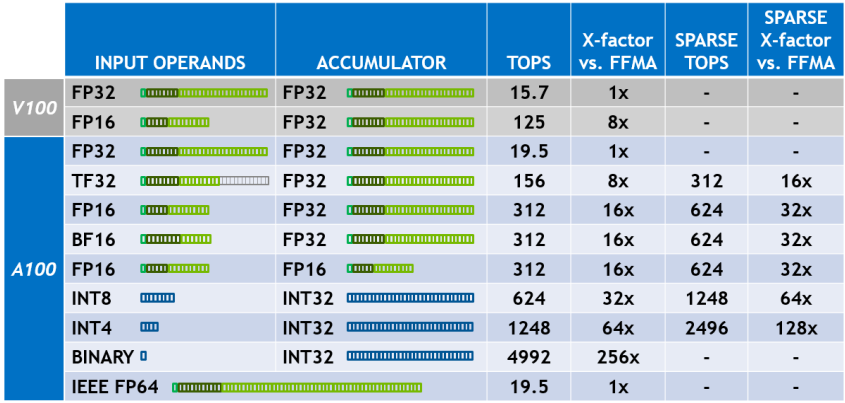

[NVIDIA Ampere Architecture Whitepaper](https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf)

## Reducing Data Types: From Float32 to TensorFloat32 (TF32)
TensorFloat32 (TF32) is a computational format designed to accelerate matrix multiplications while maintaining numerical stability. It is particularly useful for deep learning workloads on NVIDIA GPUs.

### Understanding TF32 in Matrix Multiplications

The input operand refers to the numbers being multiplied in matrix multiplications.

TF32 Input Operand:
- Uses 10-bit mantissa (instead of 23-bit in FP32).

The accumulator is where the results of multiplications are summed up during matrix multiplications (e.g., in matrix-matrix multiplications).
TF32 Accumulator:
- Although the inputs have lower precision (10-bit mantissa), the accumulation happens in full FP32 (23-bit mantissa).

### TF32 is Not a Data Type
- Unlike FP32, FP16, or INT8, TF32 is not a format that can be explicitly stored in memory.
- Instead, TF32 computations are performed at the hardware level, but all stored values remain in FP32 format.

In [ ]:
###################-Changes-######################
torch.set_float32_matmul_precision('high')
## highest -> FP32
## high -> TP32
## medium -> BF16 not recommended (for BF use torch.autocast)
##################################################

model = NMT_Transformer(vocab_size=vocab_size,
                    dim_embed=dim_embed,
                    dim_model=dim_model,
                    dim_feedforward=dim_feedforward,
                    num_layers=num_layers,
                    dropout_probability=dropout_probability,
                    maxlen=maxlen)
model.to('cuda')

optimizer = torch.optim.AdamW(model.parameters() ,lr=3e-4)

dts = []
for i in range(number_of_steps):
    t1 = time.time()
    x = data_x[i].to('cuda')
    y = data_y[i].to('cuda')

    optimizer.zero_grad()
    logits, loss = model(x, y, 0)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t2 = time.time()
    dt = (t2 - t1)*1000
    dts.append(round(dt, 2))
    print(f"step {i}, loss: {loss.item():.2f}, dt: {dt:.2f}ms")
results["TF32"] = dts
print(logits.dtype)

step 0, loss: 8.57, dt: 485.42ms
step 1, loss: 8.63, dt: 375.30ms
step 2, loss: 8.61, dt: 377.14ms
step 3, loss: 8.60, dt: 375.05ms
step 4, loss: 8.61, dt: 376.04ms
step 5, loss: 8.59, dt: 380.01ms
step 6, loss: 8.60, dt: 381.30ms
step 7, loss: 8.58, dt: 382.51ms
step 8, loss: 8.59, dt: 375.97ms
step 9, loss: 8.57, dt: 377.80ms
step 10, loss: 8.59, dt: 381.28ms
step 11, loss: 8.58, dt: 385.90ms
step 12, loss: 8.58, dt: 388.09ms
step 13, loss: 8.57, dt: 385.71ms
step 14, loss: 8.57, dt: 387.24ms
step 15, loss: 8.57, dt: 385.37ms
step 16, loss: 8.57, dt: 386.28ms
step 17, loss: 8.57, dt: 386.79ms
step 18, loss: 8.57, dt: 388.25ms
step 19, loss: 8.57, dt: 386.14ms
torch.float32


 As you may observe that logits type is still float32, but this is ok as TensorFloat32 is not a storage format

## Reducing Data Types to BrainFloat16 (BF16)

BrainFloat16 (BF16) is a lower-precision floating-point format designed to improve computational efficiency while maintaining numerical stability in deep learning tasks.

### BF16 vs. FP16
 - You can reduce the precision to Float16 (FP16) for performance gains, but FP16 has a lower mantissa precision compared to BF16.
 - When using FP16, you need to apply a gradient scaler (e.g., torch.amp.GradScaler) to prevent numerical instability during training.

In [17]:
model = NMT_Transformer(vocab_size=vocab_size,
                    dim_embed=dim_embed,
                    dim_model=dim_model,
                    dim_feedforward=dim_feedforward,
                    num_layers=num_layers,
                    dropout_probability=dropout_probability,
                    maxlen=maxlen)
model.to('cuda')

optimizer = torch.optim.AdamW(model.parameters() ,lr=3e-4)

dts = []
for i in range(number_of_steps):
    t1 = time.time()
    x = data_x[i].to('cuda')
    y = data_y[i].to('cuda')

    optimizer.zero_grad()
    ###################-Changes-######################
    ## only do model forward and loss calculations inside autocast context
    ## to use torch.float16 you will need to use gradscaler
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        logits, loss = model(x, y, 0)
    ##################################################
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t2 = time.time()
    dt = (t2 - t1)*1000
    dts.append(round(dt, 2))
    print(f"step {i}, loss: {loss.item():.2f}, dt: {dt:.2f}ms")
results["BF16"] = dts
print(logits.type())

step 0, loss: 8.58, dt: 1124.07ms
step 1, loss: 8.63, dt: 221.94ms
step 2, loss: 8.62, dt: 222.62ms
step 3, loss: 8.60, dt: 221.68ms
step 4, loss: 8.61, dt: 222.46ms
step 5, loss: 8.58, dt: 747.42ms
step 6, loss: 8.60, dt: 225.76ms
step 7, loss: 8.59, dt: 227.54ms
step 8, loss: 8.59, dt: 225.77ms
step 9, loss: 8.57, dt: 226.55ms
step 10, loss: 8.58, dt: 224.77ms
step 11, loss: 8.58, dt: 222.19ms
step 12, loss: 8.58, dt: 226.65ms
step 13, loss: 8.59, dt: 231.82ms
step 14, loss: 8.58, dt: 224.42ms
step 15, loss: 8.58, dt: 224.67ms
step 16, loss: 8.58, dt: 221.99ms
step 17, loss: 8.58, dt: 221.90ms
step 18, loss: 8.57, dt: 222.73ms
step 19, loss: 8.57, dt: 227.17ms
torch.cuda.BFloat16Tensor


- Form now, we will continue using the BF16 data type while stacking other optimizations.
- Some of the upcoming optimizations may not work on older GPUs like NVIDIA P100 and T4.

## torch.compile – **A Game Changer**

torch.compile brings significant performance improvements by optimizing PyTorch models at runtime. It primarily achieves this through two key optimizations:
1. Reducing Python Overhead:
    - torch.compile compiles the entire model (or function), allowing PyTorch to analyze and optimize the execution as if it were written in C++.
    - This minimizes Python’s dynamic execution overhead and enables more efficient computation.

2. Reducing GPU Read/Writes:
    - Since PyTorch now has a global view of your model, it can apply kernel fusion to optimize operations.
    - Kernel fusion reduces redundant GPU memory accesses, improving efficiency and execution speed.

To better understand kernel fusion, you can watch this explanation: [Kernel Fusion explanation video](https://www.youtube.com/watch?v=PBdpNhaBxfc)

In [18]:
model = NMT_Transformer(vocab_size=vocab_size,
                    dim_embed=dim_embed,
                    dim_model=dim_model,
                    dim_feedforward=dim_feedforward,
                    num_layers=num_layers,
                    dropout_probability=dropout_probability,
                    maxlen=maxlen)
model.to('cuda')
###################-Changes-######################
model = torch.compile(model, mode="reduce-overhead")
## mode specifies what the compiler should be optimizing while compiling.
##      "default": compile efficiently without taking too long to compile or using extra memory.
##      "reduce-overhead": reduce the framework overhead by a lot more, but cost a small amount of extra memory.
##      "max-autotune": compiles for a long time, trying to give you the fastest code it can generate.
##################################################
optimizer = torch.optim.AdamW(model.parameters() ,lr=3e-4)

dts = []
for i in range(number_of_steps):
    t1 = time.time()
    x = data_x[i].to('cuda')
    y = data_y[i].to('cuda')

    optimizer.zero_grad()
    ###################-Changes-######################
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        logits, loss = model(x, y, 0)
    ##################################################
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t2 = time.time()
    dt = (t2 - t1)*1000
    dts.append(round(dt, 2))
    print(f"step {i}, loss: {loss.item():.2f}, dt: {dt:.2f}ms")
results["BF16+TC"] = dts
print(logits.type())

W0302 17:54:28.141000 5443 torch/_inductor/utils.py:1137] [0/0_1] Not enough SMs to use max_autotune_gemm mode


step 0, loss: 8.58, dt: 108770.06ms
step 1, loss: 8.64, dt: 1376.54ms
step 2, loss: 8.61, dt: 175.19ms
step 3, loss: 8.61, dt: 168.29ms
step 4, loss: 8.58, dt: 169.81ms
step 5, loss: 8.59, dt: 172.43ms
step 6, loss: 8.59, dt: 172.27ms
step 7, loss: 8.58, dt: 169.86ms
step 8, loss: 8.59, dt: 171.13ms
step 9, loss: 8.59, dt: 170.33ms
step 10, loss: 8.58, dt: 169.26ms
step 11, loss: 8.58, dt: 171.12ms
step 12, loss: 8.58, dt: 170.53ms
step 13, loss: 8.58, dt: 170.80ms
step 14, loss: 8.56, dt: 174.60ms
step 15, loss: 8.57, dt: 184.15ms
step 16, loss: 8.56, dt: 190.05ms
step 17, loss: 8.57, dt: 189.92ms
step 18, loss: 8.57, dt: 186.96ms
step 19, loss: 8.58, dt: 185.58ms
torch.cuda.BFloat16Tensor


## FlashAttention
[FlashAttention Paper](https://arxiv.org/abs/2205.14135)

FlashAttention is a specialized kernel fusion optimization designed to improve the efficiency of attention mechanisms in deep learning models. Unlike torch.compile, which applies general optimizations, FlashAttention specifically targets self-attention computations.

### How FlashAttention Works

- The authors of FlashAttention rearranged the causal attention algorithm to minimize memory overhead.
- They used online softmax approach to efficiently perform kernel fusion [Online softmax Paper](https://arxiv.org/abs/1805.02867).
- This reduces redundant memory reads/writes, significantly improving training speed and memory efficiency.

### Performance Gains
- FlashAttention performs more FLOPs than regular attention but achieves a 7.6× speedup in attention computation.
- The key reason behind this acceleration is the reduction in memory access times, the algorithm never explicitly stores (materializes) the attention matrix, eliminating costly memory operations.

PyTorch provides different optimized implementations of Scaled Dot Product Attention (SDPA), including FlashAttention, Memory-Efficient SDPA, and Math-based SDPA. These implementations vary in speed and memory efficiency based on hardware availability.

1. FlashAttention (flash_sdp)
    - `torch.backends.cuda.enable_flash_sdp()`: Globally enables or disables FlashAttention.
    - Highly optimized for NVIDIA GPUs with Ampere (RTX 30xx, A100) or newer architectures.
    - Typically the fastest option if supported.

2. Memory-Efficient Attention (mem_efficient_sdp)
    - `torch.backends.cuda.enable_mem_efficient_sdp()`: Globally enables or disables Memory-Efficient Attention.
    - Works across more hardware than FlashAttention.
    - Often provides performance benefits similar to FlashAttention but with slightly higher memory usage.

3. Math-based Attention (math_sdp)
    - `torch.backends.cuda.enable_math_sdp()`: Globally enables or disables the PyTorch C++ implementation.
    - A fallback, purely mathematical implementation.
    - Usually the slowest and most memory-intensive.
    - Used when no hardware-optimized SDPA is available.

(GPT-4o generated)

### Automatic Selection in PyTorch

By default, PyTorch automatically selects the best available SDPA implementation when you use `torch.nn.functional.scaled_dot_product_attention(query, key, value)` API or Transformer layer (As we did in this notebook):
1. flash_sdp (if supported)
2. mem_efficient_sdp (if flash_sdp is disabled or unsupported)
3. math_sdp (last fallback option)

For more details, refer to the official PyTorch documentation:
[PyTorch Documentation on scaled_dot_product_attention](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html)

In [26]:
## to Check Available Options:
print("Flash Attention Enabled:", torch.backends.cuda.flash_sdp_enabled())
print("Memory Efficient Attention Enabled:", torch.backends.cuda.mem_efficient_sdp_enabled())
print("Math Attention Enabled:", torch.backends.cuda.math_sdp_enabled())

Flash Attention Enabled: False
Memory Efficient Attention Enabled: False
Math Attention Enabled: True


In [ ]:
###################-Changes-######################
## Re-enable flash and mem_efficient attentions and .
torch.backends.cuda.enable_flash_sdp(enabled=True)
torch.backends.cuda.enable_mem_efficient_sdp(enabled=True)
##################################################

model = NMT_Transformer(vocab_size=vocab_size,
                    dim_embed=dim_embed,
                    dim_model=dim_model,
                    dim_feedforward=dim_feedforward,
                    num_layers=num_layers,
                    dropout_probability=dropout_probability,
                    maxlen=maxlen)
model.to('cuda')
###################-Changes-######################
model = torch.compile(model, mode="reduce-overhead")
##################################################
optimizer = torch.optim.AdamW(model.parameters() ,lr=3e-4)

dts = []
for i in range(number_of_steps):
    t1 = time.time()
    x = data_x[i].to('cuda')
    y = data_y[i].to('cuda')

    optimizer.zero_grad()
    ###################-Changes-######################
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        logits, loss = model(x, y, 0)
    ##################################################
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t2 = time.time()
    dt = (t2 - t1)*1000
    dts.append(round(dt, 2))
    print(f"step {i}, loss: {loss.item():.2f}, dt: {dt:.2f}ms")
results["BF16+TC+FA"] = dts
print(logits.type())


step 0, loss: 8.57, dt: 1370.61ms
step 1, loss: 8.63, dt: 190.48ms
step 2, loss: 8.63, dt: 183.07ms
step 3, loss: 8.59, dt: 187.05ms
step 4, loss: 8.60, dt: 181.42ms
step 5, loss: 8.60, dt: 180.87ms
step 6, loss: 8.59, dt: 180.70ms
step 7, loss: 8.59, dt: 180.75ms
step 8, loss: 8.57, dt: 183.63ms
step 9, loss: 8.58, dt: 180.67ms
step 10, loss: 8.58, dt: 181.14ms
step 11, loss: 8.58, dt: 179.58ms
step 12, loss: 8.57, dt: 183.46ms
step 13, loss: 8.58, dt: 183.76ms
step 14, loss: 8.58, dt: 182.51ms
step 15, loss: 8.57, dt: 182.83ms
step 16, loss: 8.56, dt: 182.23ms
step 17, loss: 8.57, dt: 182.84ms
step 18, loss: 8.57, dt: 183.75ms
step 19, loss: 8.57, dt: 181.55ms
torch.cuda.BFloat16Tensor


## Fused optimizer
In PyTorch's AdamW optimizer, the `fused` and `foreach` parameters control how the optimization step is performed under the hood. Here’s the difference between them:
1. `fused` (Default: `None`):
- When `fused=True`, PyTorch uses a fused CUDA kernel for optimization updates.
- This can lead to faster training on GPUs by reducing memory operations and kernel launch overhead.
- Requires the model's parameters to be on the GPU.
- If `fused=True` but fusion is not supported for some reason (e.g., non-GPU tensors), PyTorch will fall back to the standard implementation.

2. `foreach` (Default: `None`):
- When `foreach=True`, PyTorch applies updates in a batched way instead of looping through each parameter individually.
- This is beneficial for both CPU and GPU training, offering speed improvements by reducing Python overhead.
- If `foreach=None`, PyTorch automatically decides whether to use foreach-based updates.

Note: `fused` and `foreach` cannot be `True` together.

You can learn more at [PyTorch Documentation on AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)

In [31]:
model = NMT_Transformer(vocab_size=vocab_size,
                    dim_embed=dim_embed,
                    dim_model=dim_model,
                    dim_feedforward=dim_feedforward,
                    num_layers=num_layers,
                    dropout_probability=dropout_probability,
                    maxlen=maxlen)
model.to('cuda')
###################-Changes-######################
model = torch.compile(model, mode="reduce-overhead")
##################################################
###################-Changes-######################
optimizer = torch.optim.AdamW(model.parameters() ,lr=3e-4, fused=True)
## fused and foreach cannot be True together.
##################################################

dts = []
for i in range(number_of_steps):
    t1 = time.time()
    x = data_x[i].to('cuda')
    y = data_y[i].to('cuda')

    optimizer.zero_grad()
    ###################-Changes-######################
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        logits, loss = model(x, y, 0)
    ##################################################
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t2 = time.time()
    dt = (t2 - t1)*1000
    dts.append(round(dt, 2))
    print(f"step {i}, loss: {loss.item():.2f}, dt: {dt:.2f}ms")
results["BF16+TC+FA+FuO"] = dts
print(logits.type())

step 0, loss: 8.57, dt: 1822.96ms
step 1, loss: 8.66, dt: 206.46ms
step 2, loss: 8.61, dt: 203.35ms
step 3, loss: 8.60, dt: 207.05ms
step 4, loss: 8.59, dt: 205.07ms
step 5, loss: 8.60, dt: 201.60ms
step 6, loss: 8.59, dt: 204.53ms
step 7, loss: 8.58, dt: 202.52ms
step 8, loss: 8.59, dt: 203.50ms
step 9, loss: 8.58, dt: 203.43ms
step 10, loss: 8.58, dt: 201.87ms
step 11, loss: 8.58, dt: 203.68ms
step 12, loss: 8.58, dt: 202.92ms
step 13, loss: 8.59, dt: 205.46ms
step 14, loss: 8.58, dt: 204.77ms
step 15, loss: 8.57, dt: 203.57ms
step 16, loss: 8.57, dt: 202.92ms
step 17, loss: 8.58, dt: 201.67ms
step 18, loss: 8.57, dt: 203.14ms
step 19, loss: 8.57, dt: 203.65ms
torch.cuda.BFloat16Tensor


## others
1. Gradiant clipping
2. LR Scheduler
3. Nice numbers

## Save Results for ploting

In [21]:
results.to_csv("./results.csv")

## Resources

- [NVIDIA Ampere Architecture Whitepaper](https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf)
- [PyTorch Documentation on set_float32_matmul_precision](https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html)
- [PyTorch Documentation on Automatic Mixed Precision](https://pytorch.org/docs/stable/amp.html)
- [PyTorch Documentation on torch.compile](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html)
- [PyTorch Documentation on scaled_dot_product_attention](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html)
- [FlashAttention Paper](https://arxiv.org/abs/2205.14135)
- [Online softmax Paper](https://arxiv.org/abs/1805.02867)